# PRICING THE VOLATILITY SWAP USING CONSTANT BLACK & SCHOLES MODEL UNDER CONSTANT VOLATILITY

In [ ]:
!pip install sobol-seq
!pip install tbb

     |████████████████████████████████| 4.1MB 7.0MB/s 


IMPORT RELEVANT LIBRARIES

In [ ]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from time import time
import sobol_seq
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf
from sympy import init_printing
import random

#Visualizing Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Split the dataset
from sklearn.model_selection import train_test_split

#Normalize the dataset
from sklearn.preprocessing import MinMaxScaler

#Create the model
from keras import Input
from keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#Evaluate the model
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

#Multithreading
from numba import jit,njit, config, threading_layer

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


INPUT PARAMETERS FOR CALL & PUT OPTION, VARIANCE AND VOLATILITY SWAP

In [ ]:
#Input Parameters:
# S: spot price
# K_array: array of strike prices
# T: time to maturity
# r: Risk free interest rate
# sigma_array: array of volatilities of underlying asset
# n: number of strike prices for approximation
S = 1020#float(input("Spot Price = "))
r = 0.04#float(input("Risk free interest rate in decimal = "))
T = 0.25#float(input("Time in months = "))/12
n = 9#int(input("How many strike prices do you want to enter? :"))
SD_avg_variance = 0.01
K_array = np.array([800,850,900,950,1000,1050,1100,1150,1200])
#vol_array = np.array([0.29,0.28,0.27,0.26,0.25,0.24,0.23,0.22,0.21])
SD_avg_variance = 0.01
principal = 100#million dollars
paid_vol = 0.23#paid volatility

CALCULATE F0:


In [ ]:
F0 = S * np.exp(r*T)
print("F0=",F0)

F0= 1030.2511704258513


CALCULATE S*


In [ ]:
S_star = 0
for i in range(n):
    if(K_array[i]<F0):
        S_star = K_array[i]
    else:
        break

print(S_star)

1000


In [ ]:
def euro_vanilla_call(S, K_call, T, r, vol_call):
   
    d1 = (np.log(S / K_call) + (r + 0.5 * vol_call ** 2) * T) / (vol_call * np.sqrt(T))
    d2 = (np.log(S / K_call) + (r - 0.5 * vol_call ** 2) * T) / (vol_call * np.sqrt(T))

    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K_call * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))

    return call

In [ ]:
def euro_vanilla_put(S,K_put,T,r,vol_put):
    
    d1 = (np.log(S / K_put) + (r + 0.5 * vol_put ** 2) * T) / (vol_put * np.sqrt(T))
    d2 = (np.log(S / K_put) + (r - 0.5 * vol_put ** 2) * T) / (vol_put * np.sqrt(T))

    put = ((K_put*np.exp(-r*T)* si.norm.cdf(-d2,0.0,1.0)) - (S * si.norm.cdf(-d1, 0.0, 1.0)))
    
    return put

CALCULATE THE APPROXIMATION FUNCTION

In [ ]:
def Q(K_Q,vol_Q):
    if(K_Q < S_star):
        return euro_vanilla_put(S,K_Q,T,r,vol_Q)
    elif(K_Q > S_star):
        return euro_vanilla_call(S,K_Q,T,r,vol_Q)
    elif(K_Q == S_star):
        return (0.5*(euro_vanilla_call(S,K_Q,T,r,vol_Q) + euro_vanilla_put(S,K_Q,T,r,vol_Q)))

In [ ]:
def approx(n,K,vol):
    approxed = 0
    for i in range(n):
        if(i == 0):
            delta_K = K[1] - K[0]
        elif(i >= 1 and i <= (n-2)):
            delta_K = 0.5*(K[i+1] - K[i-1])
        else:
            delta_K = K[i] - K[i-1]
        approxed += (delta_K/K[i]**2)*np.exp(r*T)*Q(K[i],vol[i])
    
    return approxed

VALUE THE VOLATILITY SWAP

In [ ]:
def volatility_swap(vol_array):
    Expected_variance_price = ((2/T)*np.log(F0/S_star)) - ((2/T)*((F0/S_star)-1)) + ((2/T)*approx(n,K_array,vol_array))
    #print(Expected_variance_price)
    var_bar = SD_avg_variance**2
    Expected_vol_price = np.sqrt(Expected_variance_price) * (1 - ((1/8)*(var_bar/Expected_variance_price**2)))
    #print(Expected_vol_price)
    swap_price = principal*((Expected_vol_price - paid_vol)*np.exp(-r*T))
    #print(swap_price)
    #return round(swap_price,2)
    return swap_price

In [ ]:
volatility_swap(np.array([0.29,0.28,0.27,0.26,0.25,0.24,0.23,0.22,0.21]))

1.7761940425724816

# ANN FOR FAST PREDICTION OF SWAP PRICE FOR DIFFERENT VOLATILITES OF THE UNDERLYING

CREATE DATASET FOR TRAINING AND TESTING

In [ ]:
round(random.uniform(50.50, 500.50), 2)

307.49

In [ ]:
df = pd.DataFrame()
df['Sigma1'] = np.random.uniform(0.2,0.6,1000000)
df['Sigma2'] = np.random.uniform(0.2,0.6,1000000)
df['Sigma3'] = np.random.uniform(0.2,0.6,1000000)
df['Sigma4'] = np.random.uniform(0.2,0.6,1000000)
df['Sigma5'] = np.random.uniform(0.2,0.6,1000000)
df['Sigma6'] = np.random.uniform(0.2,0.6,1000000)
df['Sigma7'] = np.random.uniform(0.2,0.6,1000000)
df['Sigma8'] = np.random.uniform(0.2,0.6,1000000)
df['Sigma9'] = np.random.uniform(0.2,0.6,1000000)

#df = round(df,2)

df

,Sigma1,Sigma2,Sigma3,Sigma4,Sigma5,Sigma6,Sigma7,Sigma8,Sigma9
0,0.566112,0.465958,0.206930,0.407574,0.500670,0.564315,0.332249,0.324428,0.564469
1,0.556269,0.506850,0.313259,0.452980,0.393666,0.484757,0.345936,0.539861,0.574729
2,0.577217,0.205450,0.522009,0.355574,0.430149,0.565506,0.352227,0.503809,0.395840
3,0.486204,0.263333,0.472796,0.591504,0.298740,0.393468,0.351547,0.346432,0.444187
4,0.558517,0.232624,0.393309,0.254422,0.409031,0.527585,0.408740,0.315202,0.378234
...,...,...,...,...,...,...,...,...,...
999995,0.319219,0.439904,0.569632,0.350193,0.474548,0.510800,0.583514,0.353221,0.475620
999996,0.404504,0.215001,0.262104,0.226461,0.381425,0.298641,0.496023,0.313943,0.513095
999997,0.501005,0.357932,0.226633,0.275796,0.392505,0.277055,0.427020,0.543148,0.246774
999998,0.414424,0.399121,0.247482,0.366483,0.357625,0.329986,0.270809,0.222088,0.526260


In [ ]:
%%time
df['Swap Price'] = [volatility_swap(np.array(df.loc[x,:].values)) for x in range(1000000)]

CPU times: user 39min 1s, sys: 2min 21s, total: 41min 23s
Wall time: 38min 15s


In [ ]:
df

,Sigma1,Sigma2,Sigma3,Sigma4,Sigma5,Sigma6,Sigma7,Sigma8,Sigma9,Swap Price
0,0.315699,0.296761,0.492697,0.380812,0.458356,0.595305,0.550193,0.505010,0.338467,18.239751
1,0.425359,0.333196,0.203899,0.439249,0.547067,0.311228,0.337775,0.580026,0.223251,13.735260
2,0.301369,0.481476,0.598509,0.536923,0.423904,0.449820,0.466943,0.518354,0.564526,21.128184
3,0.532343,0.547209,0.263670,0.505458,0.368612,0.442494,0.323394,0.488251,0.304966,16.530578
4,0.450506,0.453044,0.506189,0.500346,0.284136,0.487196,0.506551,0.515358,0.220384,18.031803
...,...,...,...,...,...,...,...,...,...,...
9995,0.387541,0.501126,0.343789,0.264203,0.417322,0.307275,0.332555,0.467238,0.286493,12.042590
9996,0.458114,0.489728,0.461926,0.318790,0.371646,0.490841,0.595863,0.440407,0.446100,18.354496
9997,0.395812,0.407319,0.351811,0.529293,0.314632,0.468473,0.316840,0.211521,0.253720,12.581864
9998,0.356289,0.351813,0.500286,0.504051,0.558816,0.399909,0.585904,0.334587,0.348231,18.421847


In [ ]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
X

array([[0.31569929, 0.29676074, 0.49269742, ..., 0.55019293, 0.50501011,
        0.33846684],
       [0.42535858, 0.33319566, 0.20389937, ..., 0.3377751 , 0.5800262 ,
        0.22325069],
       [0.30136929, 0.48147551, 0.59850869, ..., 0.46694342, 0.51835428,
        0.56452558],
       ...,
       [0.39581231, 0.40731934, 0.35181066, ..., 0.31684006, 0.21152115,
        0.2537203 ],
       [0.35628869, 0.35181299, 0.50028613, ..., 0.58590366, 0.33458668,
        0.34823096],
       [0.58007978, 0.44775359, 0.24352365, ..., 0.37221504, 0.35423883,
        0.22986405]])

In [ ]:
X.shape

(10000, 9)

SPLIT THE DATASET

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
y_test.shape

(3000,)

NORMALIZE THE DATASET

In [ ]:
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

CREATE THE MODEL

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [ ]:
model = Sequential()

model.add(Dense(9,activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(9,activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(9,activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(9,activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [ ]:
%%time
with tf.device('/device:GPU:0'):
  model.fit(x=X_train, y=y_train, epochs=1000,
            validation_data=(X_test, y_test),batch_size = 128, 
            verbose=1, callbacks=[early_stop])

Epoch 1/1000
55/55 [==============================] - 0s 7ms/step - loss: 197.3303 - val_loss: 151.7973
Epoch 2/1000
55/55 [==============================] - 0s 4ms/step - loss: 100.6612 - val_loss: 31.0812
Epoch 3/1000
55/55 [==============================] - 0s 4ms/step - loss: 35.9325 - val_loss: 6.1854
Epoch 4/1000
55/55 [==============================] - 0s 4ms/step - loss: 31.1147 - val_loss: 6.6468
Epoch 5/1000
55/55 [==============================] - 0s 4ms/step - loss: 28.6708 - val_loss: 6.4146
Epoch 6/1000
55/55 [==============================] - 0s 4ms/step - loss: 26.1647 - val_loss: 6.3388
Epoch 7/1000
55/55 [==============================] - 0s 4ms/step - loss: 24.3280 - val_loss: 5.9252
Epoch 8/1000
55/55 [==============================] - 0s 4ms/step - loss: 23.2901 - val_loss: 5.7565
Epoch 9/1000
55/55 [==============================] - 0s 4ms/step - loss: 22.3782 - val_loss: 5.7656
Epoch 10/1000
55/55 [==============================] - 0s 4ms/step - loss: 21.4751 - v

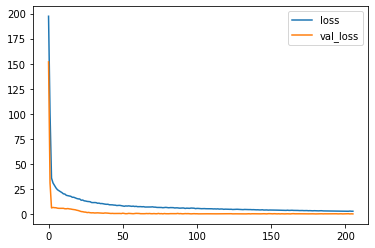

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [ ]:
y_test

array([15.81033467, 18.71489648,  9.99736173, ..., 12.13598207,
       13.39542586, 19.23552297])

In [ ]:
predictions = model.predict(X_test)
predictions

array([[15.975969],
       [18.621649],
       [10.691629],
       ...,
       [12.463562],
       [13.073429],
       [18.821327]], dtype=float32)

In [ ]:
np.sqrt(mean_squared_error(y_test,predictions))

0.46633298390852657

In [ ]:
explained_variance_score(y_test,predictions)

0.9762129512287232

In [ ]:
result_df = pd.DataFrame()
result_df['True values'] = y_test
result_df['Predictions'] = predictions
result_df

,True values,Predictions
0,15.810335,15.975969
1,18.714896,18.621649
2,9.997362,10.691629
3,17.636960,17.266794
4,15.433450,15.575157
...,...,...
2995,14.035750,13.697926
2996,12.230762,12.391105
2997,12.135982,12.463562
2998,13.395426,13.073429


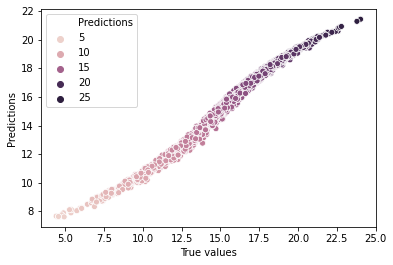

In [ ]:
sns.scatterplot(x = result_df['True values'], y = result_df['Predictions'], hue = "Predictions", data = result_df)

# ANN USING TWIN NETWORK

In [ ]:
input_tensor = Input(shape=(None,9))
l1 = layers.Dense(9,activation='softplus')(input_tensor)
tf.keras.layers.Dropout(rate=0.2)
l2 = layers.Dense(9, activation='softplus')(l1)
tf.keras.layers.Dropout(rate=0.2)
l3 = layers.Dense(9,activation='softplus')(l2)
tf.keras.layers.Dropout(rate=0.2)
l4 = layers.Dense(9,activation='softplus')(l3)
tf.keras.layers.Dropout(rate=0.2)
output = layers.Dense(1)(l4)
l5 = layers.Dense(9,activation='sigmoid')(output)
tf.keras.layers.Dropout(rate=0.2)
l6 = layers.Dense(9,activation='sigmoid')(l3)
tf.keras.layers.Dropout(rate=0.2)
l7 = layers.Dense(9,activation='sigmoid')(l3)
tf.keras.layers.Dropout(rate=0.2)
l8 = layers.Dense(9,activation='sigmoid')(l3)
tf.keras.layers.Dropout(rate=0.2)
output_tensor = layers.Dense(9)(l8)

model_TN = Model(input_tensor,[output,output_tensor])

model_TN.summary()

model_TN.compile(optimizer='adam',loss='mse')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 9)]    0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, None, 9)      90          input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, None, 9)      90          dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, None, 9)      90          dense_6[0][0]                    
_______________________________________________________________________________________

In [ ]:
%%time
model_TN.fit(x=X_train, y=y_train, epochs=2000,
          validation_data=(X_test, y_test),batch_size = 128, 
          verbose=1, callbacks=[early_stop])

Epoch 1/2000
55/55 [==============================] - 1s 9ms/step - loss: 408.2701 - dense_9_loss: 189.8652 - dense_14_loss: 218.4049 - val_loss: 368.0501 - val_dense_9_loss: 154.9221 - val_dense_14_loss: 213.1280
Epoch 2/2000
55/55 [==============================] - 0s 6ms/step - loss: 302.7183 - dense_9_loss: 98.9719 - dense_14_loss: 203.7464 - val_loss: 226.7685 - val_dense_9_loss: 29.9944 - val_dense_14_loss: 196.7741
Epoch 3/2000
55/55 [==============================] - 0s 6ms/step - loss: 196.4344 - dense_9_loss: 8.7940 - dense_14_loss: 187.6405 - val_loss: 187.9365 - val_dense_9_loss: 5.9193 - val_dense_14_loss: 182.0173
Epoch 4/2000
55/55 [==============================] - 0s 6ms/step - loss: 178.5280 - dense_9_loss: 5.4275 - dense_14_loss: 173.1005 - val_loss: 171.7700 - val_dense_9_loss: 5.5311 - val_dense_14_loss: 166.2389
Epoch 5/2000
55/55 [==============================] - 0s 6ms/step - loss: 162.5228 - dense_9_loss: 5.0498 - dense_14_loss: 157.4730 - val_loss: 157.0544 -

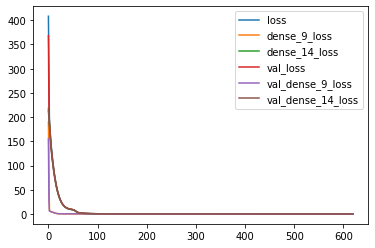

In [ ]:
model_loss = pd.DataFrame(model_TN.history.history)
model_loss.plot()

In [ ]:
predictions = model_TN.predict(X_test)
predictions

[array([[15.85364 ],
        [18.667889],
        [10.154156],
        ...,
        [12.208869],
        [13.35763 ],
        [19.152866]], dtype=float32),
 array([[15.853533, 15.848686, 15.846228, ..., 15.847078, 15.853299,
         15.850801],
        [18.699324, 18.702284, 18.702812, ..., 18.701149, 18.700705,
         18.701807],
        [10.147136, 10.137468, 10.143947, ..., 10.132139, 10.142564,
         10.136511],
        ...,
        [12.193449, 12.199344, 12.198813, ..., 12.198003, 12.196786,
         12.198474],
        [13.383968, 13.391096, 13.386312, ..., 13.394348, 13.387536,
         13.394094],
        [19.156517, 19.157717, 19.156803, ..., 19.156223, 19.157715,
         19.15767 ]], dtype=float32)]

In [ ]:
np.sqrt(mean_squared_error(y_test,predictions[0]))

0.11305163164997559

In [ ]:
explained_variance_score(y_test,predictions[0])

0.9987473305979403

In [ ]:
result_df = pd.DataFrame()
result_df['True values'] = y_test
result_df['Predictions'] = predictions[0]

result_df

,True values,Predictions
0,15.810335,15.853640
1,18.714896,18.667889
2,9.997362,10.154156
3,17.636960,17.593699
4,15.433450,15.363018
...,...,...
2995,14.035750,13.856400
2996,12.230762,12.135015
2997,12.135982,12.208869
2998,13.395426,13.357630


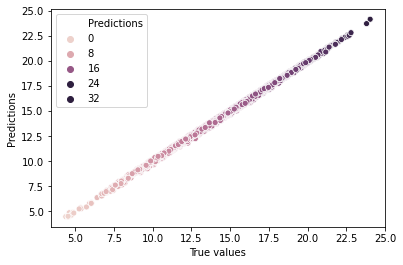

In [ ]:
sns.scatterplot(x = result_df['True values'], y = result_df['Predictions'], hue = "Predictions", data = result_df)

# DEVELOPING THE TERM STRUCTURE OF THE VOLATILITY SWAP

In [ ]:
def bs_vega(S,K,T,r,v,q=0.0):
    d1 = (np.log(S/K)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    return S * np.sqrt(T)*si.norm.pdf(d1)

In [ ]:
def find_vol(target_value, S, K, T, r):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        if (K < S):
          price = euro_vanilla_call(S,K,T,r,sigma)
          vega = bs_vega(S, K, T, r, sigma)
          diff = target_value - price  # our root
          #print (i,sigma, diff)
          if (abs(diff) < PRECISION):
              return sigma, i
          sigma = sigma + diff/vega # f(x) / f'(x)
        elif (K > S):
          price = euro_vanilla_put(S,K,T,r,sigma)
          vega = bs_vega(S, K, T, r, sigma)
          diff = target_value - price  # our root
          #print (i,sigma, diff)
          if (abs(diff) < PRECISION):
              return sigma, i
          sigma = sigma + diff/vega # f(x) / f'(x)

    iteration = i
    # value wasn't found, return best guess so far
    return sigma, iteration

In [ ]:
def local_vol(S0,S,volvol, rho, sigma):
    x = np.log(S/S0)
    volvec = volvol * volvol * x * x;
    volvec += 2.0 * volvol * rho * sigma * x;
    volvec += sigma * sigma;
    volvec = np.sqrt(volvec);
    return volvec;

In [ ]:
#region Monte Carlo

np.random.seed(20000)

# Parameters
S0 = 1000.; T = 1.0; r = 0.0;
sigma = 0.20;
volvol = 0.50;
rho = -0.750;
rhoBar = np.sqrt(1.0-rho*rho);

M = 20; dt = T / M; I = 15000
# Simulating I paths with M time steps

S = np.zeros((M + 1, I))
Sbs = np.zeros((M + 1, I))
Slv = np.zeros((M + 1, I))
vol = np.zeros((M + 1, I))
vollv= np.zeros((M + 1, I))
Slv[0] = S0
Sbs[0] = S0
S[0] = S0
vol[0] = sigma
vollv[0] = sigma

z = sobol_seq.i4_sobol_generate(2*M,I);

for t in range(1, M + 1):
 z1 = z[:,t-1];
 z2 = z[:,M+t-1];
 x1 = norm.ppf(z1);
 x2 = norm.ppf(z2);

 vol[t] = vol[t - 1] * np.exp((- 0.5 * volvol ** 2) * dt + volvol * math.sqrt(dt) * (rho*x1+rhoBar*x2))
 S[t] = S[t - 1] * np.exp((r - 0.5 * vol[t-1] ** 2) * dt + vol[t-1] * math.sqrt(dt) * x1)
 Sbs[t] = Sbs[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * x1)
 Slv[t] = Slv[t - 1] * np.exp((r - 0.5 * vollv[t-1] ** 2) * dt + vollv[t-1] * math.sqrt(dt) * x1)
 vollv[t] =  local_vol(S0, Slv[t], volvol, rho, sigma)


In [ ]:
Slv[-1].shape

(15000,)

In [ ]:

# Calculating the Monte Carlo estimator
Kmin =  math.exp(-2.0*sigma*math.sqrt(T))
sigma_array = np.array([0.29,0.28,0.27,0.26,0.25,0.24,0.23,0.22,0.21])
C0 = [];
iv = [];
calc = [];
ivBS = [];
ivLV = [];

total_bs = 0
total_lv = 0
total_sv = 0

for i in range(len(K_array)):
      #calc.append(K_array[i])
      clv = math.exp(-r * T) * np.sum( np.maximum(Slv[-1] - K_array[i], 0) - np.maximum(Sbs[-1] - K_array[i], 0) ) / I + euro_vanilla_call(S0,K_array[i],T,r,sigma_array[i])
      cbs = math.exp(-r * T) * np.sum( np.maximum(Sbs[-1] - K_array[i], 0) ) / I
      csv = math.exp(-r * T) * np.sum( np.maximum(S[-1] - K_array[i], 0) - np.maximum(Sbs[-1] - K_array[i], 0) ) / I + euro_vanilla_call(S0,K_array[i],T,r,sigma_array[i])
      plv = math.exp(-r * T) * np.sum( np.maximum(K_array[i] - Slv[-1], 0) - np.maximum(K_array[i] - Sbs[-1], 0) ) / I + euro_vanilla_put(S0,K_array[i],T,r,sigma_array[i])
      pbs = math.exp(-r * T) * np.sum( K_array[i] - np.maximum(Sbs[-1], 0) ) / I
      psv = math.exp(-r * T) * np.sum( K_array[i] - np.maximum(S[-1], 0) - np.maximum(K_array[i] - Sbs[-1], 0) ) / I + euro_vanilla_put(S0,K_array[i],T,r,sigma_array[i])
      if i==0:
        delta_K = K_array[i+1] - K_array[i]
        if K_array[i] < S_star:
          total_bs += ((delta_K/K_array**2)*np.exp(r*T)*math.exp(-r * T) * np.sum( K_array[i] - np.maximum(Sbs[-1], 0) ) / I)
          total_lv += ((delta_K/K_array**2)*np.exp(r*T)*math.exp(-r * T) * np.sum( np.maximum(K_array[i] - Slv[-1], 0) - np.maximum(K_array[i] - Sbs[-1], 0) ) / I + euro_vanilla_put(S0,K_array[i],T,r,sigma_array[i]))
          total_sv += ((delta_K/K_array**2)*np.exp(r*T)*math.exp(-r * T) * np.sum( K_array[i] - np.maximum(S[-1], 0) - np.maximum(K_array[i] - Sbs[-1], 0) ) / I + euro_vanilla_put(S0,K_array[i],T,r,sigma_array[i])) 
          break
        elif K_array[i] > S_star:
          total_bs += ((delta_K/K_array**2)*np.exp(r*T)*math.exp(-r * T) * np.sum( np.maximum(Sbs[-1] - K_array[i], 0) ) / I)
          total_lv += ((delta_K/K_array**2)*math.exp(-r * T) * np.sum( np.maximum(Slv[-1] - K_array[i], 0) - np.maximum(Sbs[-1] - K_array[i], 0) ) / I + euro_vanilla_call(S0,K_array[i],T,r,sigma_array[i]))
          total_sv += ((delta_K/K_array**2)*math.exp(-r * T) * np.sum( np.maximum(S[-1] - K_array[i], 0) - np.maximum(Sbs[-1] - K_array[i], 0) ) / I + euro_vanilla_call(S0,K_array[i],T,r,sigma_array[i]))
          break
        break

      elif ((i>=1) and (i<=n-2)):
        delta_K = 0.5*(K_array[i+1] - K_array[i-1])
        if K_array[i] < S_star:
          total_bs += ((delta_K/K_array**2)*np.exp(r*T)*math.exp(-r * T) * np.sum( K_array[i] - np.maximum(Sbs[-1], 0) ) / I)
          total_lv += ((delta_K/K_array**2)*np.exp(r*T)*math.exp(-r * T) * np.sum( np.maximum(K_array[i] - Slv[-1], 0) - np.maximum(K_array[i] - Sbs[-1], 0) ) / I + euro_vanilla_put(S0,K_array[i],T,r,sigma_array[i]))
          total_sv += ((delta_K/K_array**2)*np.exp(r*T)*math.exp(-r * T) * np.sum( K_array[i] - np.maximum(S[-1], 0) - np.maximum(K_array[i] - Sbs[-1], 0) ) / I + euro_vanilla_put(S0,K_array[i],T,r,sigma_array[i])) 
          break
        elif K_array[i] > S_star:
          total_bs += ((delta_K/K_array**2)*np.exp(r*T)*math.exp(-r * T) * np.sum( np.maximum(Sbs[-1] - K_array[i], 0) ) / I)
          total_lv += ((delta_K/K_array**2)*math.exp(-r * T) * np.sum( np.maximum(Slv[-1] - K_array[i], 0) - np.maximum(Sbs[-1] - K_array[i], 0) ) / I + euro_vanilla_call(S0,K_array[i],T,r,sigma_array[i]))
          total_sv += ((delta_K/K_array**2)*math.exp(-r * T) * np.sum( np.maximum(S[-1] - K_array[i], 0) - np.maximum(Sbs[-1] - K_array[i], 0) ) / I + euro_vanilla_call(S0,K_array[i],T,r,sigma_array[i]))
          break
        break

      else:
        delta_K = K_array[i] - K_array[i-1]
        if K_array[i] < S_star:
          total_bs += ((delta_K/K_array**2)*np.exp(r*T)*math.exp(-r * T) * np.sum( K_array[i] - np.maximum(Sbs[-1], 0) ) / I)
          total_lv += ((delta_K/K_array**2)*np.exp(r*T)*math.exp(-r * T) * np.sum( np.maximum(K_array[i] - Slv[-1], 0) - np.maximum(K_array[i] - Sbs[-1], 0) ) / I + euro_vanilla_put(S0,K_array[i],T,r,sigma_array[i]))
          total_sv += ((delta_K/K_array**2)*np.exp(r*T)*math.exp(-r * T) * np.sum( K_array[i] - np.maximum(S[-1], 0) - np.maximum(K_array[i] - Sbs[-1], 0) ) / I + euro_vanilla_put(S0,K_array[i],T,r,sigma_array[i])) 
          break
        elif K_array[i] > S_star:
          total_bs += ((delta_K/K_array**2)*np.exp(r*T)*math.exp(-r * T) * np.sum( np.maximum(Sbs[-1] - K_array[i], 0) ) / I)
          total_lv += ((delta_K/K_array**2)*math.exp(-r * T) * np.sum( np.maximum(Slv[-1] - K_array[i], 0) - np.maximum(Sbs[-1] - K_array[i], 0) ) / I + euro_vanilla_call(S0,K_array[i],T,r,sigma_array[i]))
          total_sv += ((delta_K/K_array**2)*math.exp(-r * T) * np.sum( np.maximum(S[-1] - K_array[i], 0) - np.maximum(Sbs[-1] - K_array[i], 0) ) / I + euro_vanilla_call(S0,K_array[i],T,r,sigma_array[i]))
          break
        break


In [ ]:
j_bs

array([-0.03213439, -0.0285675 , -0.02557841, -0.02304874, -0.02088896,
       -0.0190303 , -0.01741929, -0.01601381, -0.01478033])

In [ ]:
j_bs = ((2/T)*np.log(F0/S_star)) - ((2/T)*((F0/S_star)-1)) + ((2/T)*total_bs)
j_lv = ((2/T)*np.log(F0/S_star)) - ((2/T)*((F0/S_star)-1)) + ((2/T)*total_bs)
j_sv = ((2/T)*np.log(F0/S_star)) - ((2/T)*((F0/S_star)-1)) + ((2/T)*total_bs)
var_bar = SD_avg_variance**2
vol_price_bs = np.sqrt(j_bs) * (1 - ((1/8)*(var_bar/j_bs**2)))
swap_price_bs = principal*((vol_price_bs - paid_vol)*np.exp(-r*T))
vol_price_lv = np.sqrt(j_lv) * (1 - ((1/8)*(var_bar/j_lv**2)))
swap_price_lv = principal*((vol_price_lv - paid_vol)*np.exp(-r*T))
vol_price_sv = np.sqrt(j_sv) * (1 - ((1/8)*(var_bar/j_sv**2)))
swap_price_sv = principal*((vol_price_sv - paid_vol)*np.exp(-r*T))
      

In [ ]:
iv.append(find_vol(swap_price_sv, S0,S_star,T,r))
ivBS.append(find_vol(swap_price_bs, S0,S_star,T,r))
ivLV.append(find_vol(swap_price_lv, S0,S_star,T,r))

In [ ]:
swap_price_bs

array([ -28.1004235 ,  -31.4120858 ,  -35.49041231,  -40.60217361,
        -47.12579719,  -55.61643689,  -66.91941151,  -82.37891265,
       -104.24755153])